In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
import random
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from ml_utilities.data import get_dataset_label_names
import itertools

# 22-cf10-resnet-Finetune-subclasses

Train a resnet-20 on 3 cifar10 classes and then finetune to other 3 classes. 

## Find Hyperparameters

In [3]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids:
  - 0
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler
seeds:
- 0
start_num: 0

config:
  experiment_data:
    entity: fslgroup 
    project_name: tflearning
    experiment_tag: '22.0'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-B-subclass
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq: null
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
        - out_channels: 16
          num_residual_blocks: 3
        - out_channels: 32
          num_residual_blocks: 3
        - out_channels: 64
          num_residual_blocks: 3
      linear_output_units:
        - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 32000 #64000.0
    log_train_step_every: 10
    log_additional_train_step_every: 20
    val_every: 500
    save_every: 64000.0
    early_stopping_patience: 64000.0
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      # lr_scheduler_name: MultiStepLR
      # lr_scheduler_kwargs:
      #   milestones:
      #   - 32000.0
      #   - 48000.0
      #   gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

    enable_cov_analysis: False #True
    cov_analysis_args:
      num_batches: 25
      use_tqdm: False
  
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: null
      joint_tensor_transforms: null
      enable_transforms: true
    use_classes:
    - automobile
    - dog 
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [4]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

python run.py --config-name cifar10-22.0.0-resnet-B-subclass.yaml


### Finetune class combinations

In [9]:
pretrain_classes = set(['automobile', 'dog', 'horse'])

In [7]:
# create random class tuples
cf10_labels = get_dataset_label_names('cifar10')
cf10_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [24]:
finetune_labels = list(set(cf10_labels) - pretrain_classes)

In [25]:
finetune_class_tuples = list(itertools.combinations(finetune_labels, len(pretrain_classes)))
random.shuffle(finetune_class_tuples)

In [27]:
for fct in finetune_class_tuples[:5]:
    print(list(fct))

['frog', 'truck', 'airplane']
['ship', 'bird', 'deer']
['frog', 'bird', 'deer']
['truck', 'bird', 'deer']
['ship', 'cat', 'truck']


### Pretrain steps

In [30]:
pretrain_job = JobResult('/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-A-cifar10-23.0.0-resnet-sc-automobile_dog_horse--230213_110007')
pretrain_job

JobResult(/system/user/publicwork/beck/projects/regularization/tflearning/outputs/IA-A-cifar10-23.0.0-resnet-sc-automobile_dog_horse--230213_110007)

In [32]:
pretrain_job.is_successful_job, pretrain_job.available_model_checkpoint_indices

(True,
 [0,
  5,
  10,
  30,
  50,
  100,
  250,
  500,
  1000,
  2000,
  4000,
  5000,
  6000,
  8000,
  10000,
  12000,
  14000,
  15000,
  15000,
  16000,
  18000,
  20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  32001])

In [ ]:
 x = [0,
  5,
  10,
  30,
  50,
  100,
  250,
  500,
  1000,]

## Finetune Hypsearch cfg

In [48]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [4,5,6,7]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler
seeds:
- 0

sweep:
  type: grid
  axes: 
  - parameter: data.use_classes
    vals:
    - ['frog', 'truck', 'airplane']
    # - ['ship', 'bird', 'deer']
    # - ['frog', 'bird', 'deer']
    # - ['truck', 'bird', 'deer']
    # - ['ship', 'cat', 'truck']
  # - parameter: init_model_step
  #   vals: [0,5,10,30,50,100,250,500,1000, 5000, 10000, 15000, 20000, 24000, 30000, 32000]
  - parameter: data.dataset_split.restrict_n_samples_train_task
    vals: [500, 2000, 5000, 10000, 20000]
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
    vals: [0.1, 0.01, 0.001]
  

start_num: 0

config:
  experiment_data:
    entity: fslgroup 
    project_name: tflearning
    experiment_tag: '22.2'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-subclass-fthyps
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
      mode: offline
    watch:
      log: null
      log_freq: null
  
  init_model_step: 15000
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
        - out_channels: 16
          num_residual_blocks: 3
        - out_channels: 32
          num_residual_blocks: 3
        - out_channels: 64
          num_residual_blocks: 3
      linear_output_units:
        - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
    init_model: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-A-cifar10-23.0.0-resnet-sc-automobile_dog_horse--230213_110007/checkpoints/checkpoint-train_step--${config.init_model_step}.p
    

  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 10000 #32000 #64000.0
    log_train_step_every: 10
    log_additional_train_step_every: 20
    val_every: 500
    save_every: 64000.0
    early_stopping_patience: 64000.0
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
      # lr_scheduler_name: MultiStepLR
      # lr_scheduler_kwargs:
      #   milestones:
      #   - 32000.0
      #   - 48000.0
      #   gamma: 0.1
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

    enable_cov_analysis: False #True
    cov_analysis_args:
      num_batches: 25
      use_tqdm: False
  
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      restrict_n_samples_train_task: 300
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: null
      joint_tensor_transforms: null
      enable_transforms: true
    use_classes:
    - automobile
    - dog 
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [49]:
run_command = REPO.create_experiment(cfg, override=False)
print(run_command)

python run_sweep.py --config-name cifar10-22.2.0-resnet-subclass-fthyps.yaml


In [50]:
sweepr = REPO.get_output_loader(cfg)
sweepr

SweepResult(cifar10-22.2.0-resnet-subclass-fthyps--230213_130243)

In [51]:
# sweepr.get_summary().sort_values(by=['data.dataset_split.restrict_n_samples_train_task', 'best_val_score'], ascending=[True, False])

,best_train_step,best_val_score,data.use_classes,data.dataset_split.restrict_n_samples_train_task,trainer.optimizer_scheduler.optimizer_kwargs.lr,seed
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.1-seed-0--230213_130312,3000,0.887664,"['frog', 'truck', 'airplane']",500,0.100,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.01-seed-0--230213_130315,2500,0.880083,"['frog', 'truck', 'airplane']",500,0.010,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.001-seed-0--230213_130319,8500,0.861475,"['frog', 'truck', 'airplane']",500,0.001,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.1-seed-0--230213_130321,7000,0.933839,"['frog', 'truck', 'airplane']",2000,0.100,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.01-seed-0--230213_130323,9000,0.915231,"['frog', 'truck', 'airplane']",2000,0.010,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.001-seed-0--230213_130324,10000,0.905582,"['frog', 'truck', 'airplane']",2000,0.001,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.1-seed-0--230213_130325,9500,0.952447,"['frog', 'truck', 'airplane']",5000,0.100,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.01-seed-0--230213_130326,10000,0.937974,"['frog', 'truck', 'airplane']",5000,0.010,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.001-seed-0--230213_131217,7000,0.929014,"['frog', 'truck', 'airplane']",5000,0.001,0
cifar10-22.2.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-10000-lr-0.1-seed-0--230213_131332,9000,0.965541,"['frog', 'truck', 'airplane']",10000,0.100,0


In [47]:
# sweepr.get_summary().sort_values(by=['data.dataset_split.restrict_n_samples_train_task', 'best_val_score'], ascending=[True, False])

,best_train_step,best_val_score,data.use_classes,data.dataset_split.restrict_n_samples_train_task,trainer.optimizer_scheduler.optimizer_kwargs.lr,seed
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.1-seed-0--230213_114244,8000,0.822881,"['frog', 'truck', 'airplane']",500,0.100,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.01-seed-0--230213_114248,5000,0.795314,"['frog', 'truck', 'airplane']",500,0.010,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-500-lr-0.001-seed-0--230213_114251,8000,0.771192,"['frog', 'truck', 'airplane']",500,0.001,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.1-seed-0--230213_114254,9000,0.896623,"['frog', 'truck', 'airplane']",2000,0.100,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.01-seed-0--230213_114255,9000,0.882839,"['frog', 'truck', 'airplane']",2000,0.010,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-2000-lr-0.001-seed-0--230213_114256,3500,0.851137,"['frog', 'truck', 'airplane']",2000,0.001,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.1-seed-0--230213_114257,3000,0.921434,"['frog', 'truck', 'airplane']",5000,0.100,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.01-seed-0--230213_114258,9000,0.907650,"['frog', 'truck', 'airplane']",5000,0.010,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-5000-lr-0.001-seed-0--230213_115142,9000,0.885596,"['frog', 'truck', 'airplane']",5000,0.001,0
cifar10-22.1.0-resnet-subclass-fthyps--use_classes-frog_truck_airplane-restrict_n_samples_train_task-10000-lr-0.1-seed-0--230213_115300,8500,0.944176,"['frog', 'truck', 'airplane']",10000,0.100,0


In [ ]:
# use parameters: 
# restrict_n_samples_train_task: 2000
# lr: 0.1

## Pretrain-Finetune target tasks Pretrain sweep cfg

In [16]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [4,5,6,7]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler
seeds:
- 0

sweep:
  type: grid
  axes: 
  - parameter: data.use_classes
    vals:
    - ['frog', 'truck', 'airplane']
    - ['ship', 'bird', 'deer']
    - ['frog', 'bird', 'deer']
    - ['truck', 'bird', 'deer']
    - ['ship', 'cat', 'truck']
  - parameter: init_model_step
    vals: [0,5,10,30,50,100,250,500,1000, 5000, 10000, 15000, 20000, 24000, 30000, 32000]
  # - parameter: data.dataset_split.restrict_n_samples_train_task
  #   vals: [500, 2000, 5000, 10000, 20000]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
  #   vals: [0.1, 0.01, 0.001]
  

start_num: 0

config:
  experiment_data:
    entity: fslgroup 
    project_name: tflearning
    experiment_tag: '22.3'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-subclass-fthyps
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
      mode: offline
    watch:
      log: null
      log_freq: null
      
  init_model_step: 15000
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
        - out_channels: 16
          num_residual_blocks: 3
        - out_channels: 32
          num_residual_blocks: 3
        - out_channels: 64
          num_residual_blocks: 3
      linear_output_units:
        - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
    init_model: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-A-cifar10-23.0.0-resnet-sc-automobile_dog_horse--230213_110007/checkpoints/checkpoint-train_step--${config.init_model_step}.p
    

  
  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 10000 #32000 #64000.0
    log_train_step_every: 50
    log_additional_train_step_every: 50
    val_every: 200
    save_every: 64000.0
    early_stopping_patience: 64000.0
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4

    enable_cov_analysis: False #True
    cov_analysis_args:
      num_batches: 25
      use_tqdm: False
  
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      restrict_n_samples_train_task: 2000
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: null
      joint_tensor_transforms: null
      enable_transforms: true
    use_classes:
    - automobile
    - dog 
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [17]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [20]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 22.3(0)
Exp. Name: cifar10-22.3.0-resnet-subclass-fthyps
Training setup: supervised_cov_analysis
Model name: resnet
Dataset name: cifar10
Sweep type: grid
  data.use_classes: [['frog', 'truck', 'airplane'], ['ship', 'bird', 'deer'], ['frog', 'bird', 'deer'], ['truck', 'bird', 'deer'], ['ship', 'cat', 'truck']]
  init_model_step: [0, 5, 10, 30, 50, 100, 250, 500, 1000, 5000, 10000, 15000, 20000, 24000, 30000, 32000]
Seeds: [0]
Num. jobs: 80
Config updated: 2023-02-13 13:56:30
Sweep started:  2023-02-13 13:48:30



In [21]:
sw_summary = sweepr.get_summary(log_source='val', row_sel=('train_step', [1000, 5000, 10000]), col_sel='Accuracy')

In [24]:
sw_summary

,best_train_step,best_val_score,Accuracy-train_step-1000,Accuracy-train_step-5000,Accuracy-train_step-10000,data.use_classes,init_model_step,seed
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-frog_bird_deer-init_model_step-0-seed-0--230213_143542,9200,0.776832,0.739529,0.761126,0.719241,"['frog', 'bird', 'deer']",0,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-frog_bird_deer-init_model_step-10-seed-0--230213_143614,8000,0.755236,0.731675,0.742801,0.682592,"['frog', 'bird', 'deer']",10,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-frog_bird_deer-init_model_step-100-seed-0--230213_143642,8400,0.750000,0.721859,0.715314,0.740183,"['frog', 'bird', 'deer']",100,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-frog_bird_deer-init_model_step-1000-seed-0--230213_144716,8600,0.800393,0.686518,0.785995,0.793194,"['frog', 'bird', 'deer']",1000,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-frog_bird_deer-init_model_step-10000-seed-0--230213_144757,1800,0.799084,0.771597,0.793848,0.791885,"['frog', 'bird', 'deer']",10000,0
...,...,...,...,...,...,...,...,...
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-truck_bird_deer-init_model_step-32000-seed-0--230213_151205,3600,0.885466,0.878768,0.883456,0.880107,"['truck', 'bird', 'deer']",32000,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-truck_bird_deer-init_model_step-5-seed-0--230213_145907,3600,0.796383,0.712659,0.788346,0.772271,"['truck', 'bird', 'deer']",5,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-truck_bird_deer-init_model_step-50-seed-0--230213_145947,9800,0.798392,0.762893,0.770931,0.794374,"['truck', 'bird', 'deer']",50,0
cifar10-22.3.0-resnet-subclass-fthyps--use_classes-truck_bird_deer-init_model_step-500-seed-0--230213_150014,8200,0.829203,0.792364,0.804421,0.823845,"['truck', 'bird', 'deer']",500,0


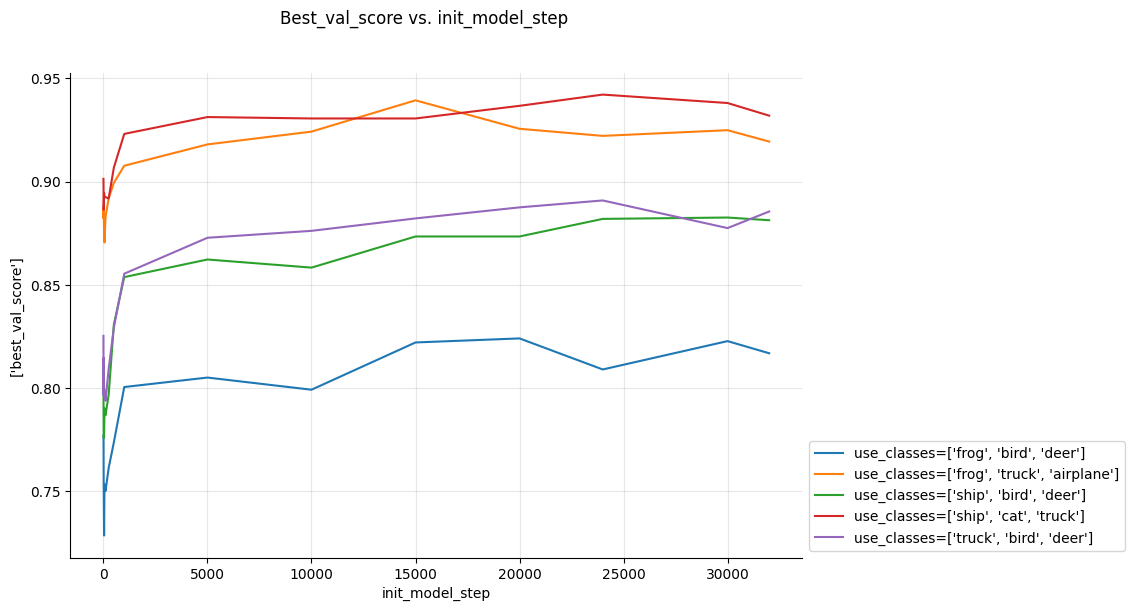

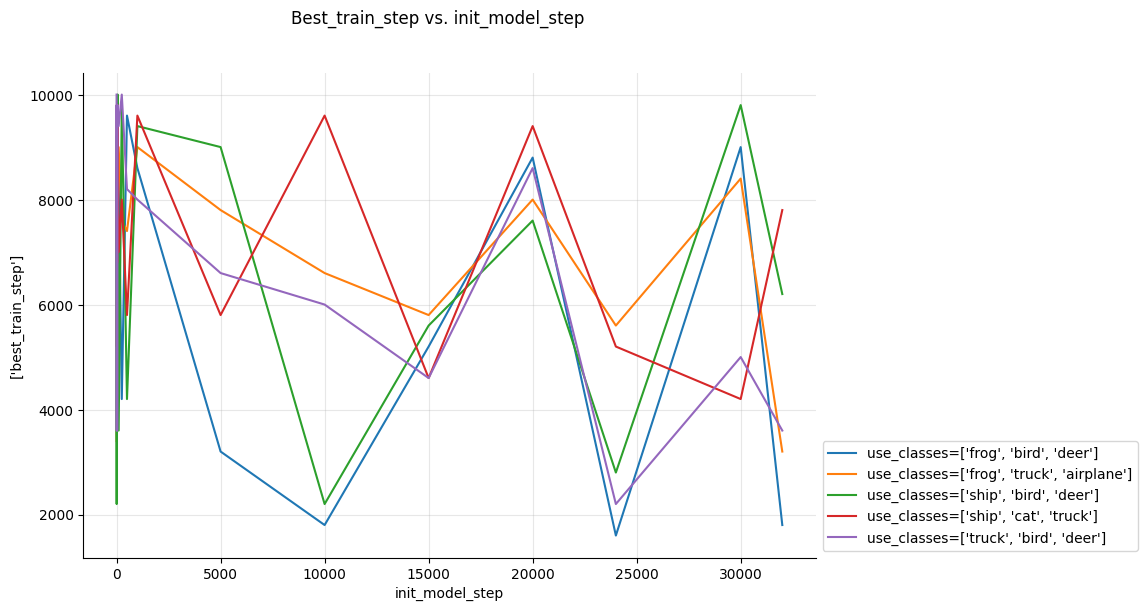

In [26]:
p1 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_val_score', compare_parameter='data.use_classes', title='Best_val_score vs. init_model_step', savefig=True)
p1 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_train_step', compare_parameter='data.use_classes', title='Best_train_step vs. init_model_step', savefig=False)

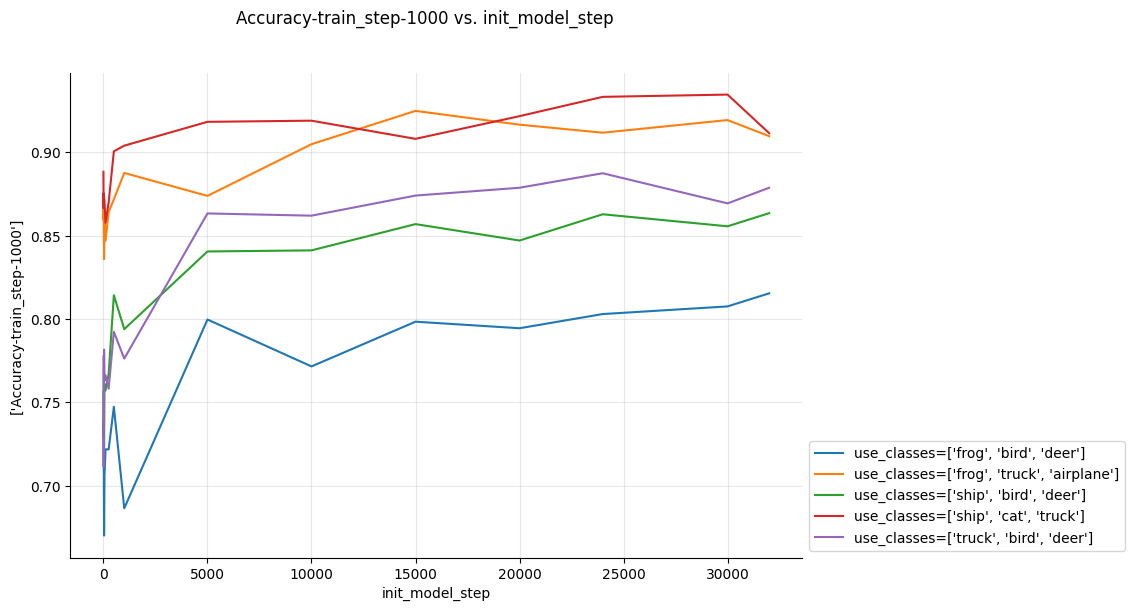

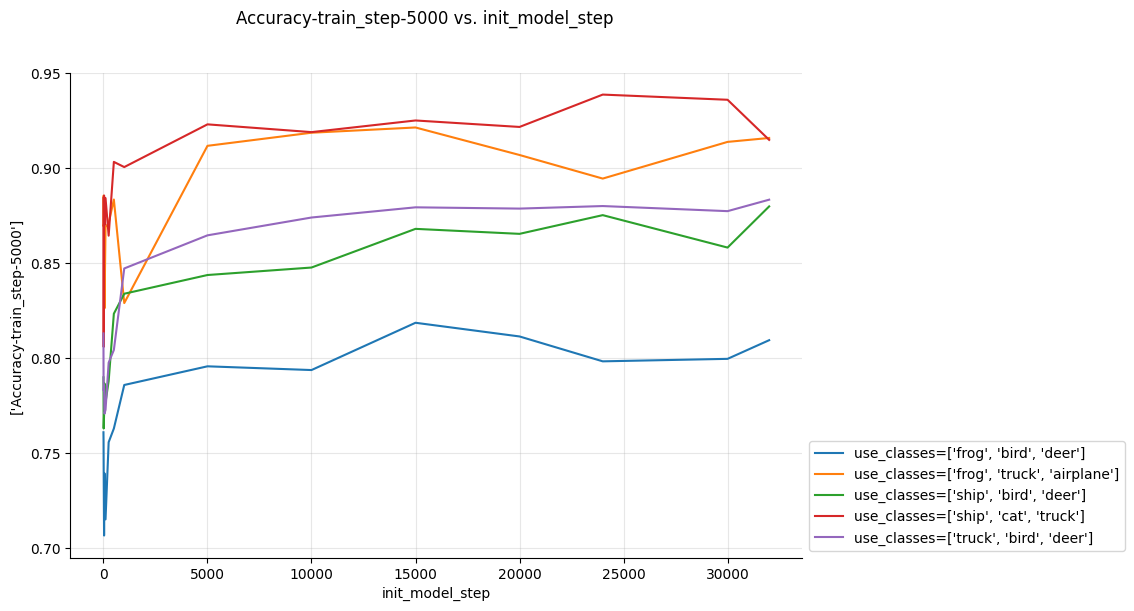

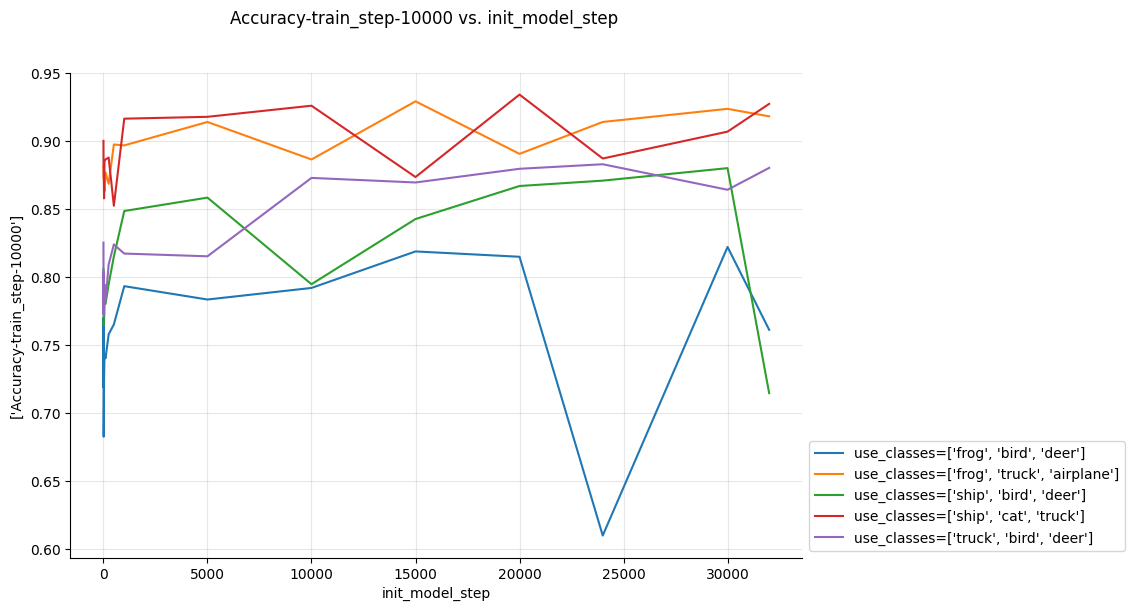

In [28]:
plot_names = ['Accuracy-train_step-1000', 'Accuracy-train_step-5000', 'Accuracy-train_step-10000']
for name in plot_names:
    p = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis=name, compare_parameter='data.use_classes', title=f'{name} vs. init_model_step', savefig=True) 

## Pretrain Covariance analysis

In [14]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [4,5,6,7]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler
seeds:
- 0

start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '22.4'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-cova-sc-automobile_dog_horse
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
  model:
    name: resnet
    model_kwargs:
      in_channels: 3
      act_fn: relu
      residual_option: B
      input_layer_config:
        kernel_size: 3
        out_channels: 16
        bias: false
        batch_norm: true
        stride: 1
        padding: 1
      resnet_blocks_config:
        - out_channels: 16
          num_residual_blocks: 3
        - out_channels: 32
          num_residual_blocks: 3
        - out_channels: 64
          num_residual_blocks: 3
      linear_output_units:
        - 3
      model_initializer: kaiming_normal
      batchnorm_initializer: uniform
  trainer:
    training_setup: supervised_cov_analysis
    n_steps: 32000 #64000.0
    log_train_step_every: 10
    log_additional_train_step_every: 20
    val_every: 500
    save_every: 32000 #2000
    early_stopping_patience: 64000.0
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.1
        momentum: 0.9
        weight_decay: 0.0001
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    enable_cov_analysis: True
    cov_analysis_args:
      num_batches: 25
      use_tqdm: False
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
    train_split_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
    use_classes:
    - automobile
    - dog 
    - horse
"""
cfg = OmegaConf.create(config_yaml)

In [15]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [12]:
sweepr = REPO.get_output_loader(cfg)
sweepr

JobResult(/system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-22.4.0-resnet-cova-sc-automobile_dog_horse--230213_140629)

In [13]:
sweepr.get_summary()

,best_train_step,best_val_score,seed
cifar10-22.4.0-resnet-cova-sc-automobile_dog_horse--230213_140629,19000,0.971729,0
